## Библиотеки, параметры, константы задачи

In [3]:
import sys

PATH_BASE = "D:\\projects\\DenoisingCNN"

sys.path.append(PATH_BASE)

from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
import numpy as np
from common.fstream import read_tensor, read_matrix, rescale_array, read_mc_tensor


NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="uvych_matrix_denoiser_5", 
                      name_dataset=NAME_DATASET, 
                      path_base=PATH_BASE,
                      device_name="cpu")
dtype = torch.double

In [2]:
import gc
gc.collect()

0

## Загрузка данных

In [2]:
import torchvision
from scipy import fftpack

def fft2d_transform(path):
    x = read_matrix(path)
    #x = torch.tensor(read_matrix(path), dtype=torch.float)
    # fft2 = torch.fft.fft2(x, norm="ortho")
    # res = torch.dstack([fft2.real, fft2.imag]).permute([2, 0, 1])
    # return res.detach().numpy()
    
    t =  np.log(fftpack.fftshift( fftpack.fft2(x)))
    return t.real #np.dstack([t.real, t.imag])
# t =  np.log(fftpack.fftshift( fftpack.fft2(x)))

env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=16
    ) \
    .load_feature(
        shape=(1, 64, 64), feature_name="Uvych_noised_re.xls", mapper=fft2d_transform, transform=None, lazy_load=False
    ) \
    .set_target(
        shape=(1, 64, 64), target_name="Uvych_re.xls", mapper=fft2d_transform, transform=None, lazy_load=False
    ) \

print(env.train_count, env.val_count)

114 26oading progress: |████████████████████████████████████████████████--| 96.2% Complete | 


In [3]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        shape=(1, 64, 64), feature_name="Uvych_noised_re.xls", mapper=read_matrix, transform=None, dtype=dtype
    ) \
    .set_target(
        shape=(1, 64, 64), target_name="Uvych_re.xls", mapper=lambda path: read_matrix(path), transform=None, dtype=dtype
    ) \

print(env.train_count, env.val_count)

114 105ading progress: |█████████████████████████████████████████████████-| 99.0% Complete | 


In [4]:
def collect_re_im(path):
    re = read_matrix(path + "_re.xls")
    im = read_matrix(path + "_im.xls")
    return np.stack((re, im))


env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        shape=(2, 64, 64), feature_name="Uvych", mapper=collect_re_im, dtype=dtype, transform=None, lazy_load=False, ignore_not_exists=True
    ) \
    .set_target(
        shape=(1, 64, 64), target_name="K_re.xls", mapper=read_matrix, dtype=dtype, transform=None, lazy_load=False, ignore_not_exists=True
    ) \

print(env.train_count, env.val_count)



227 249ading progress: |█████████████████████████████████████████████████-| 99.6% Complete | 


In [10]:
t = env.train_target_loader[0][1].shape

t

torch.Size([2, 64, 64])

In [17]:
orig = torch.fft.ifft2(fft2, norm="ortho")

In [11]:
import matplotlib.pyplot as plt
im = plt.imshow(orig.imag.cpu().detach().numpy())
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)


NameError: name 'orig' is not defined

torch.Size([2, 64, 64])

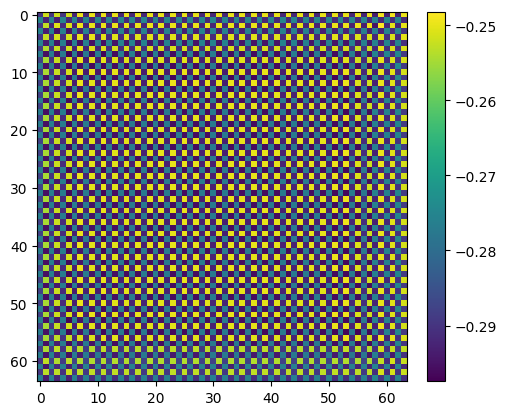

In [5]:
import matplotlib.pyplot as plt
im = plt.imshow(env.model(env.train_features_loaders[0][10][0].reshape(1, 2, 64, 64)).cpu().detach().numpy()[0][0])
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)


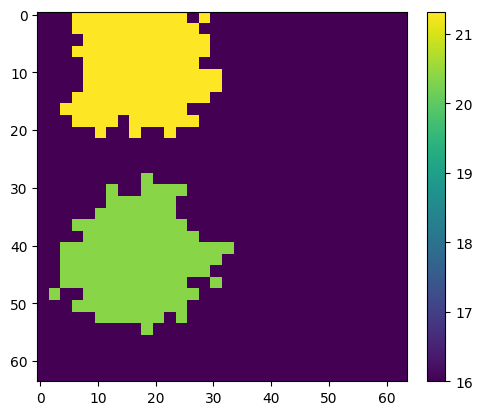

In [8]:
import matplotlib.pyplot as plt
im = plt.imshow(env.train_target_loader[0][8][0].cpu().detach().numpy())
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)

## Модели

### Новая локальная модель

In [29]:
env.set_name_model("uvych_matrix_noise_predictor_2")

In [3]:
env.model = models.autoencoders.UnetAutoencoder.UNetAuto(num_channels=1, num_out_channels=1).to(env.device)

In [26]:
env.model = models.autoencoders.unet.UNet(in_channels=1, out_channels=1, init_features=64).to(env.device)


In [9]:
env.model = models.autoencoders.purecnns.ConvAutoencoderLumaRelu5(in_channels=2, out_channels=2).to(env.device)


In [5]:
env.model = models.autoencoders.purecnns.ConvAutoencoderLumaRelu11(in_channels=2, out_channels=1, n_convs=10, n_linears=7).to(env.device)


In [3]:
env.model = models.autoencoders.res_unet.ResUnetPlusPlus(channel=1).to(env.device)

In [3]:
env.model = models.autoencoders.residual.AEv6_0(in_channels=1, out_channels=1).to(env.device)
# fm_path="/home/amedvedev/projects/python/DenoisingCNN/assets/pt/uvych_matrix_denoiser_10 (4th copy).pt"
#from torch import nn


In [4]:
env.model = models.predictors.NoiseMatrixPredictor_v1(1, 1, 80, 80, 80 * 80).to(env.device)

In [10]:
env.model = models.autoencoders.wavelet.WMDCNN(2, 4, 4, 27).to(env.device)

In [3]:
from torch import nn
class UvychDimExpand(nn.Module):
    def __init__(self, in_channels, out_channels, width, height, hidden_size):
        super(UvychDimExpand, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.width = width
        self.height = height
        self.orig_size = in_channels * width * height
        self.hidden_size = hidden_size

        self.ft = nn.Sequential(
            nn.Linear(self.orig_size, self.orig_size)
        )

        self.inv = nn.Linear(hidden_size, self.orig_size)

    def forward(self, x):
        bs = x.size()[0]
        x = x.view(bs, self.orig_size)
        x = self.ft(x)
        x = x.view(bs, self.out_channels, self.height, self.width)

        return x

env.model = UvychDimExpand(2, 2, 80, 80, 80 * 80 ).to(env.device)



In [9]:
from torch import nn
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight.data)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        # nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)

env.model.apply(weights_init)

ConvAutoencoderLumaRelu11(
  (convs): ModuleList(
    (0): Conv2d(2, 8, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (7): Conv2d(512, 1024, kernel_size=(4, 4), stride=(1, 1))
    (8): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(1, 1))
    (9-10): 2 x Conv2d(2048, 2048, kernel_size=(4, 4), stride=(1, 1))
  )
  (tconvs): ModuleList(
    (0-1): 2 x ConvTranspose2d(2048, 2048, kernel_size=(4, 4), stride=(1, 1))
    (2): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(1, 1))
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1))
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1))
    (5): ConvTranspos

In [22]:
env.model = models.autoencoders.swin_unet.SwinTransformerSys(64, in_chans=1, num_classes=1, window_size=4).to(env.device)


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


In [4]:
env.model

AEv4_0(
  (first): AEv2_0(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose3): ConvTranspose2d(64, 64, k

### Импорт претренерованной модели

In [ ]:
env.model()

In [12]:
env.load_model(model_type="pt")

Exception: 

In [7]:
env.model.to(dtype)

ConvAutoencoderLumaRelu11(
  (convs): ModuleList(
    (0): Conv2d(2, 8, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (7): Conv2d(512, 1024, kernel_size=(4, 4), stride=(1, 1))
    (8): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(1, 1))
    (9-10): 2 x Conv2d(2048, 2048, kernel_size=(4, 4), stride=(1, 1))
  )
  (tconvs): ModuleList(
    (0-1): 2 x ConvTranspose2d(2048, 2048, kernel_size=(4, 4), stride=(1, 1))
    (2): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(1, 1))
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1))
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1))
    (5): ConvTranspos

## Визуализация батча валидационного датасета

D:\projects\DenoisingCNN\.venv\Lib\site-packages\torch\_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


RuntimeError: requested resize to 4x64x64 (16384 elements in total), but the given tensor has a size of 4x2x64x64 (32768 elements). autograd's resize can only change the shape of a given tensor, while preserving the number of elements. 

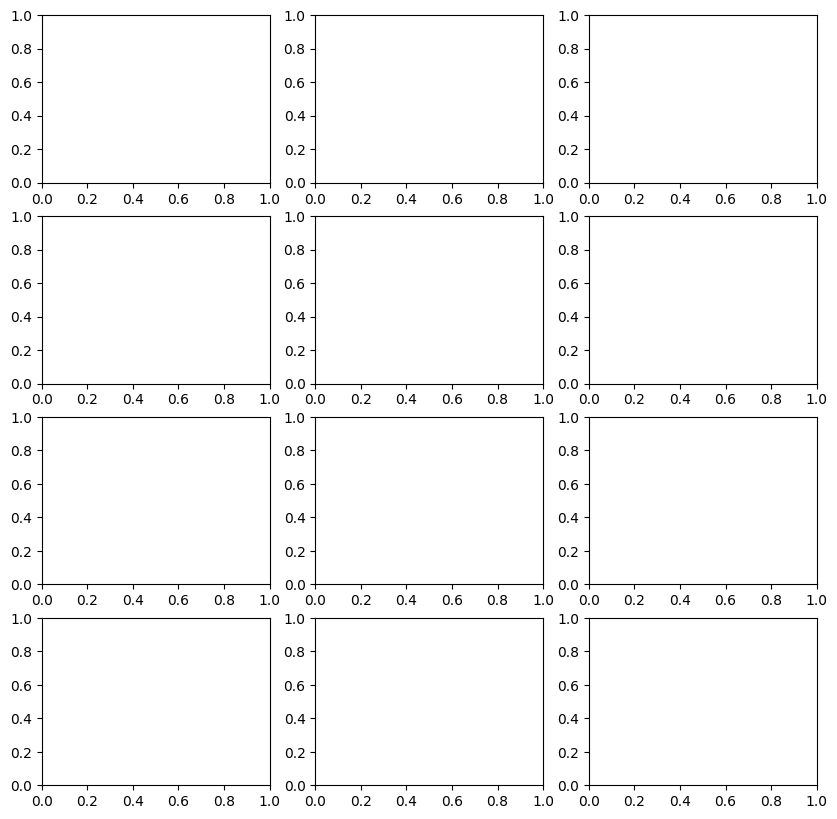

In [13]:
env.plot_batch_with_inputs(concrete=0, figsize=(10, 10), format="%.2f", wspace=0.0, hspace=0.2)


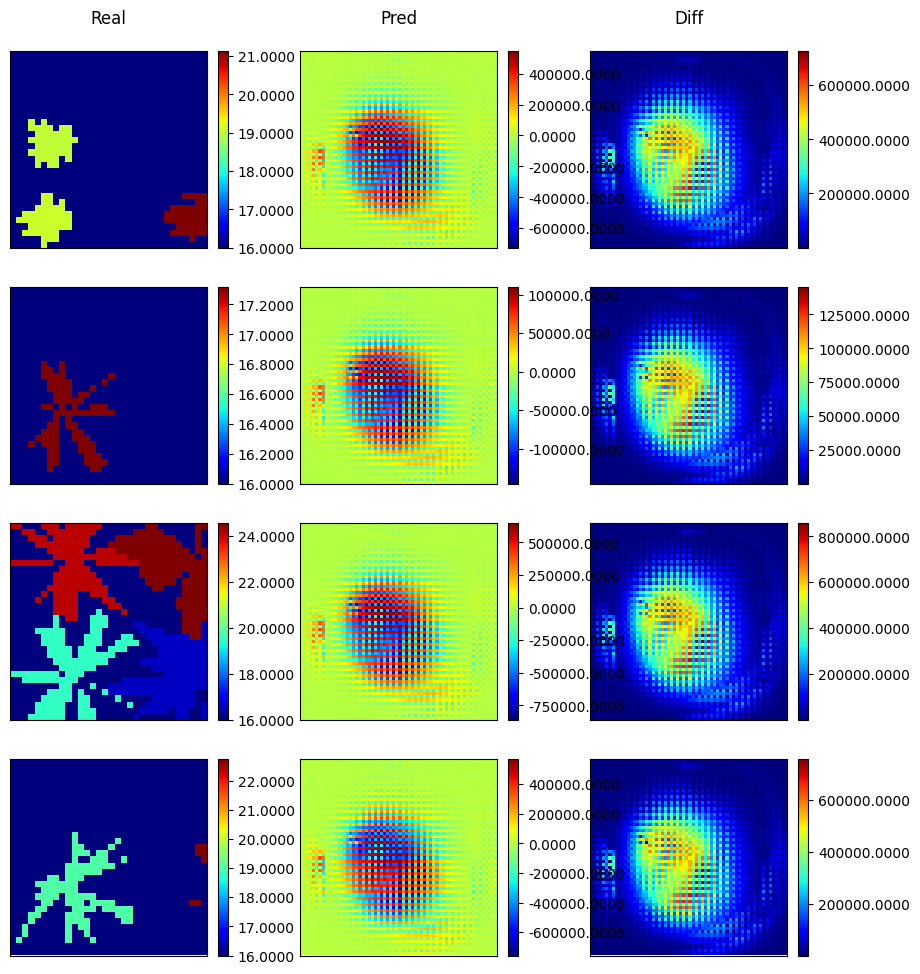

In [14]:
env.plot_batch(concrete=5, figsize=(10, 10), format="%.4f", wspace=0.0, hspace=0.2, ch_show=0)


In [7]:
env.model

AEv6_0(
  (conv0): Conv2d(1, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose0): ConvTranspose2d(80, 80, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose1): ConvTranspose2d(80, 80, kern

## Численные значения отклонений

In [11]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.

        
            
            for ex_id in range(env.val_batch_size):

                losses_dataset_step = torch.max(torch.abs(data_features[0][ex_id][0] - data_target[ex_id])).detach().tolist()
                losses_dataset.append(losses_dataset_step)

                init_error = torch.mean(torch.abs(data_features[0][ex_id][0] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
                init_errors.append(init_error.detach().tolist())

                loss = torch.max(torch.abs(outputs[ex_id] - data_target[ex_id]))
                losses.append(loss.detach().tolist())
                # print(data_target[ex_id].size())


                error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
                errors.append(error.detach().tolist())
                
    print("Начальное среднее отклонение по значениям:", sum(losses_dataset) / len(losses_dataset))
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    
    print()
    print("Начальное максимальное отклонение по значениям:", max(losses_dataset))
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    
    # print()
    # print("Начальная средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    # print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    # print()
    # print("Начальная максимальная относительная ошибка:", max(init_errors))
    # print("Текущая максимальная относительная ошибка:", max(errors))
test()

KeyboardInterrupt: 

## Training

In [18]:
from common.losses import MseCoeffLoss, L1CoeffLoss
from pytorch_msssim import MS_SSIM as _MS_SSIM


In [24]:
env.set_name_model("uvych_tensor_denoiser_2")

In [13]:
opt = torch.optim.AdamW(env.model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[int(10 * 0.6), int(10 * 0.9)], gamma=0.1)

In [16]:
class L1_MSSSIM(torch.nn.Module):
    def __init__(self):
        super(L1_MSSSIM, self).__init__()
        self.l1 = nn.L1Loss()
        self.ms_ssim = _MS_SSIM(data_range=4, size_average=True, win_size=1, channel=1)

    def forward(self, x, y):
        ms_ssim_loss = 1 - self.ms_ssim(x, y)
        l1_loss = self.l1(x, y)

        return l1_loss + ms_ssim_loss

In [12]:
from torch import nn

In [99]:
env.train(5, step_saving=True, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=L1_MSSSIM().to(env.device), 
          callbacks=[lambda: scheduler.step()]) #


NameError: name 'L1_MSSSIM' is not defined

In [12]:
opt = torch.optim.Adam(env.model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)



In [13]:
env.train(3, step_saving=True, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=torch.nn.MSELoss(reduce="none", reduction="none"),
          callbacks=[lambda: scheduler.step(env.test_losses[-1])]) #lambda: scheduler.step(env.test_losses[-1])

D:\projects\DenoisingCNN\.venv\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 808003543070626176.000000000 	Validating Loss: 425220553199.096313477 	Time: 44.96 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 245260821855.380340576 	Validating Loss: 121564508351.574249268 	Time: 44.74 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 79148905507.852111816 	Validating Loss: 50411784531.525367737 	Time: 49.56 m




## Сохранение модели

In [17]:
env.save(onnx=False, pth=False)

## Loss visualisation

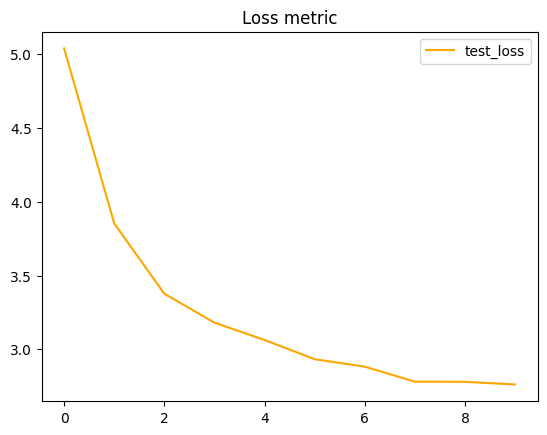

In [32]:
env.show_metrics(n_last=10, train=False, val=True)

## Clear memory

In [5]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()

In [35]:
env.model.cpu()
del env.model
import torch
torch.cuda.empty_cache()

In [6]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            
            x = data_features[0][0]
            
            fft2 = torch.fft.fft2(x, norm="ortho")

            x_fft = torch.dstack([fft2.real, fft2.imag]).view(80, 80, 2).permute([2, 0, 1])
            
            outputs_fft = env.model(x_fft) #* 65.
            
            outputs_fft_complex = torch.complex(*outputs_fft)
            
            fft2_inv = torch.fft.ifft2(outputs_fft_complex, norm="ortho")
            outputs = fft2_inv.real
            ex_id = 0
            data_target = data_target[0]
            
            losses_dataset_step = torch.max(torch.abs(data_features[0][ex_id][0] - data_target[ex_id])).detach().tolist()
            losses_dataset.append(losses_dataset_step)
            
            init_error = torch.mean(torch.abs(data_features[0][ex_id][0] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            init_errors.append(init_error.detach().tolist())
            
            loss = torch.max(torch.abs(outputs - data_target[ex_id]))
            losses.append(loss.detach().tolist())
            # print(data_target[ex_id].size())
            
            
            error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            errors.append(error.detach().tolist())
            
            # for ex_id in range(env.val_batch_size):
            #     
            #     losses_dataset_step = torch.max(torch.abs(data_features[0][ex_id][0] - data_target[ex_id])).detach().tolist()
            #     losses_dataset.append(losses_dataset_step)
            #     
            #     init_error = torch.mean(torch.abs(data_features[0][ex_id][0] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            #     init_errors.append(init_error.detach().tolist())
            #     
            #     loss = torch.max(torch.abs(outputs[ex_id] - data_target[ex_id]))
            #     losses.append(loss.detach().tolist())
            #     # print(data_target[ex_id].size())
            #     
            #     
            #     error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
            #     errors.append(error.detach().tolist())
                #print(outputs, data_target)
                
    print("Начальное среднее отклонение по значениям:", sum(losses_dataset) / len(losses_dataset))
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    
    print()
    print("Начальное максимальное отклонение по значениям:", max(losses_dataset))
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    
    print()
    print("Начальная средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    print()
    print("Начальная максимальная относительная ошибка:", max(init_errors))
    print("Текущая максимальная относительная ошибка:", max(errors))
test()

Начальное среднее отклонение по значениям: 0.026016585528850555
Текущее среднее отклонение по значениям: 2.1138689294457436

Начальное максимальное отклонение по значениям: 0.045397281646728516
Текущее максимальное отклонение по значениям в векторе: 4.617318630218506

Начальная средняя относительная ошибка: 0.005001195095246658
Текущая средняя относительная ошибка: 1.8679515551775694

Начальная максимальная относительная ошибка: 0.005064061377197504
Текущая максимальная относительная ошибка: 7.108710765838623
